In [1]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [3]:
#np.random.normal(loc = 0.3, scale=0.075, size=1)[0]

In [4]:
def noise(center, stddev=0.075):
    return np.random.normal(loc = center, scale=0.075, size=1)[0]

def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE + noise(0.1)
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE + noise(0.1)
        else:
            return USER_DISLIKED_ARTICLE + noise(0.1)
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE + noise(0.4)
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE + noise(0.4)
        else:
            return USER_DISLIKED_ARTICLE + noise(0.4)

def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE + noise(0.4)
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise(0.4)
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE + noise(0.4)
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise(0.4)
        else:
            return USER_DISLIKED_ARTICLE + noise(0.4)
        
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]



In [5]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [6]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

In [7]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [8]:
def plot_ctr(num_iterations, ctr, label):
    plt.plot(range(1,num_iterations+1), ctr, label=label)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
          fancybox=True, shadow=True, ncol=2)

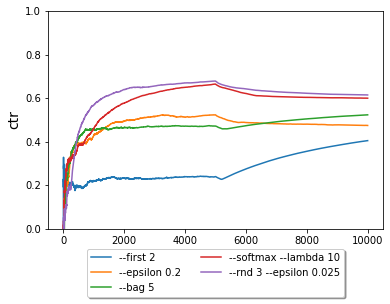

In [9]:
# use first reward function initially and then switch to second reward function

exploration_algo = ["--first 2", "--epsilon 0.2", "--bag 5", "--softmax --lambda 10", "--rnd 3 --epsilon 0.025" ]
ctr = []
plt.figure(1)
# Instantiate learner in VW
for algo in exploration_algo:
    vw = pyvw.vw("--cb_explore_adf -q UA --quiet " + algo)

    num_iterations_per_cost_func = 5000
    cost_functions = [get_cost, get_cost_new1]
    total_iterations = num_iterations_per_cost_func * len(cost_functions)

    ctr.append(run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions))

    plot_ctr(total_iterations, ctr[-1], algo)